In [1]:
import numpy as np
import pandas as pd

# plotting
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
from tbats import TBATS
from prophet import Prophet
from pmdarima import auto_arima



# make plots bigger
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

## Prophet, TBATS, SARIMAX — модели для предсказания временных рядов

### 1. Задача

Рассмотрим [датасет](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) с kaggle, с соревнования по прогнозированию спроса на товары.

In [2]:
data = pd.read_csv('../Data/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
# Задаем магазин и продукт
store, item = 1, 1

# Выделяем только те данные, которые относятся к данному магазину и продукту
data = data[(data['store'] == store) & (data['item'] == item)]

# Дату уставнавливаем как индекс
data = data.set_index('date')

# Выделяем данные о продажах
data = data['sales']

In [4]:
data, 

(date
 2013-01-01    13
 2013-01-02    11
 2013-01-03    14
 2013-01-04    13
 2013-01-05    10
               ..
 2017-12-27    14
 2017-12-28    19
 2017-12-29    15
 2017-12-30    27
 2017-12-31    23
 Name: sales, Length: 1826, dtype: int64,)

### 2. Данные
Разделим данные на train и test. test — данные за последний год.

In [5]:
test_size = 365
data_train = data.iloc[: -test_size]
data_test  = data.iloc[-test_size:]

Визуализируем данные.

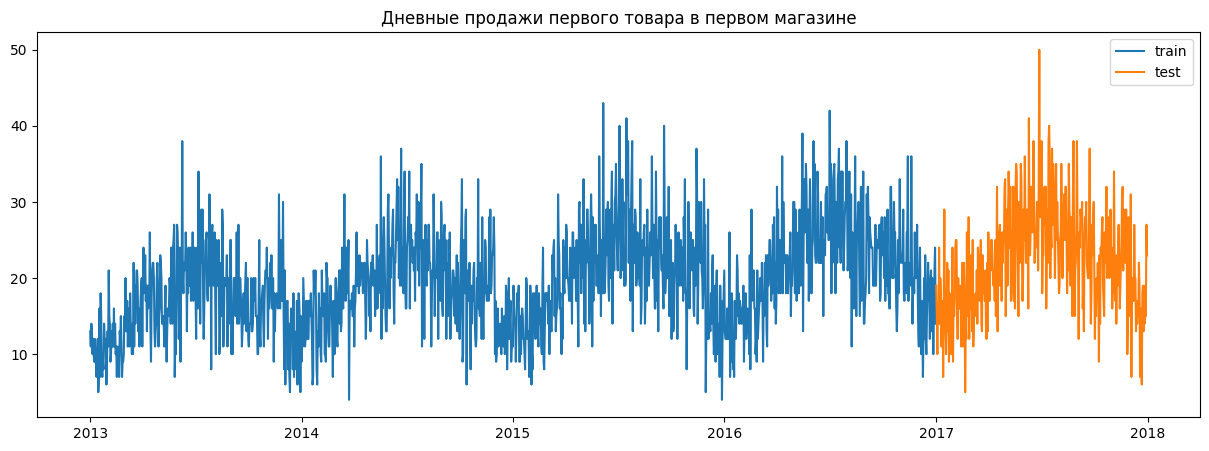

In [6]:
plt.figure(figsize=(15, 5))

plt.title('Дневные продажи первого товара в первом магазине')
plt.plot(data_train, label='train')
plt.plot(data_test, label='test')
plt.legend();

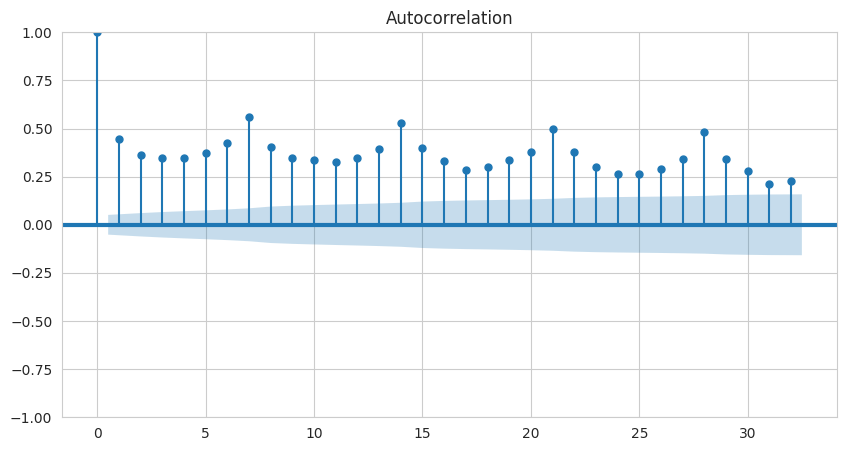

In [7]:
# Проверим, есть ли недельная сезонность.
rcParams['figure.figsize'] = 10, 5
with sns.axes_style('whitegrid'):
    statsmodels.graphics.tsaplots.plot_acf(data_train, lw=3)

Некоторая недельная сезонность есть.

### 3. Метрики
Зададим метрики качаства моделей: MSE, MAE, MAPE. Зададим функцию, которая будет вычислять метрики качества моделей и записывать их в таблицу.

In [8]:
compare_table = None


def add_results_in_comparison_table(method: str, y_true, y_forecast) -> pd.DataFrame:
    """
    Добавляет новую строчку в таблицу compare_table с результатами текущей модели.
    Если ранее модель была уже добавлена в таблицу, то старая строчка перезапишется на новую.
    
    Параметры:
    - method: имя модели
    - y_true: истинные значения
    - y_forecast: предсказанные значения.
    """
    
    # Обращаемся к глобальной переменной
    global compare_table
    
    # Считаем метрики
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast)
    }
    
    # Записываем результат в таблицу
    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table


def mean_absolute_percentage_error(y_true, y_pred) -> float: 
    """Считает MAPE для y_true и y_pred"""
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 4. Prophet

Prophet – модель, разработанная Facebook для предсказания временных рядов. 

Для начала подготовим данные, чтобы их можно было передать модели.

Модель для обучения принимает на вход датасет из 2 колонок: 
* `ds` &mdash; дата
* `y` &mdash; временой ряд

In [9]:
prophet_train_df = pd.DataFrame(data_train)
prophet_train_df.columns = ['y']
prophet_train_df['ds'] = prophet_train_df.index

In [10]:
prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(prophet_train_df)

14:49:53 - cmdstanpy - INFO - Chain [1] start processing
14:49:53 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future = prophet_model.make_future_dataframe(
    periods=test_size, include_history=False
)

y_prophet_forecast = prophet_model.predict(future)

In [12]:
y_prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,22.655334,12.529953,29.910439,22.655334,22.655334,-1.504652,-1.504652,-1.504652,3.723695,3.723695,3.723695,-5.228347,-5.228347,-5.228347,0.0,0.0,0.0,21.150682
1,2017-01-02,22.659383,4.969452,21.586359,22.659383,22.659383,-9.438402,-9.438402,-9.438402,-4.232830,-4.232830,-4.232830,-5.205571,-5.205571,-5.205571,0.0,0.0,0.0,13.220981
2,2017-01-03,22.663432,7.386918,25.244523,22.663432,22.663432,-6.835870,-6.835870,-6.835870,-1.635981,-1.635981,-1.635981,-5.199889,-5.199889,-5.199889,0.0,0.0,0.0,15.827562
3,2017-01-04,22.667480,8.033939,24.883582,22.667470,22.667505,-6.324686,-6.324686,-6.324686,-1.114474,-1.114474,-1.114474,-5.210212,-5.210212,-5.210212,0.0,0.0,0.0,16.342794
4,2017-01-05,22.671529,7.665326,24.478742,22.671497,22.671578,-5.942753,-5.942753,-5.942753,-0.707771,-0.707771,-0.707771,-5.234982,-5.234982,-5.234982,0.0,0.0,0.0,16.728776


Модель для каждой даты раскладывает свое предсказание на компоненты.

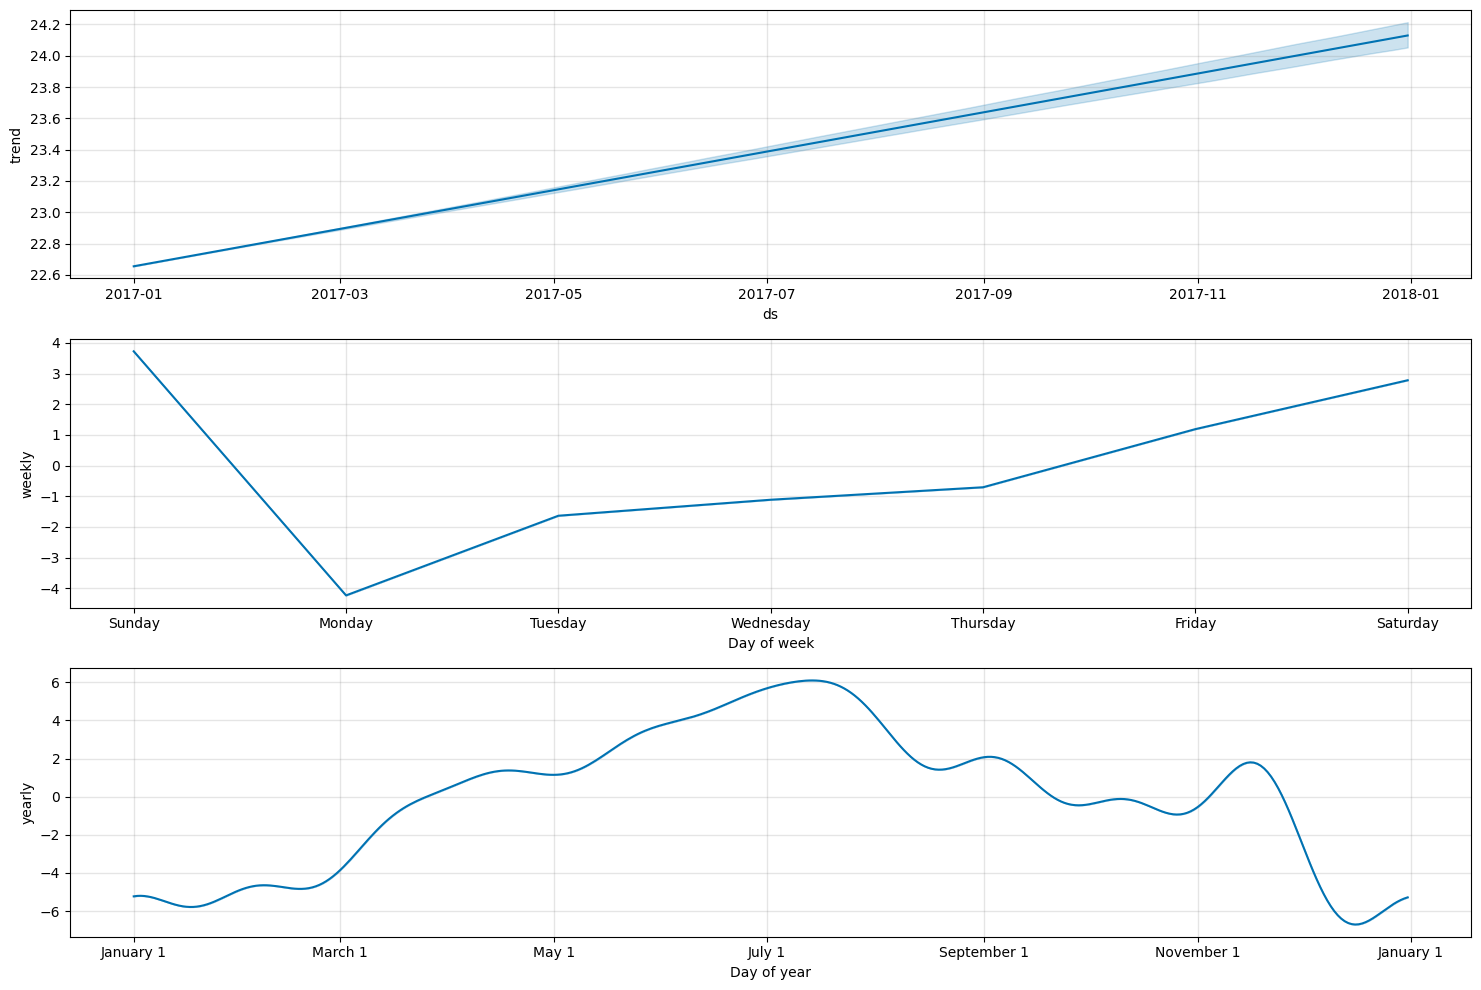

In [13]:
prophet_model.plot_components(y_prophet_forecast, figsize=(15, 10))
plt.show()

Отобразим полученные результаты.

In [14]:
def plot_results(y_to_train, y_to_test, y_forecast, plot_conf_int=True,
                 left_bound=None, right_bound=None):
                 
    plt.figure(figsize=(15, 5))
    plt.title('Дневные продажи объекта 1 в магазине 1', fontsize=15)
    plt.plot(y_to_train, label='train')
    plt.plot(y_to_test, label='test')
    plt.plot(y_to_test.index, y_forecast, label='prediction')
    if plot_conf_int:
        plt.fill_between(y_to_test.index, 
                         left_bound, right_bound, 
                         alpha=0.3, color='grey',
                         label='conf.int')
    plt.legend()
    plt.show()

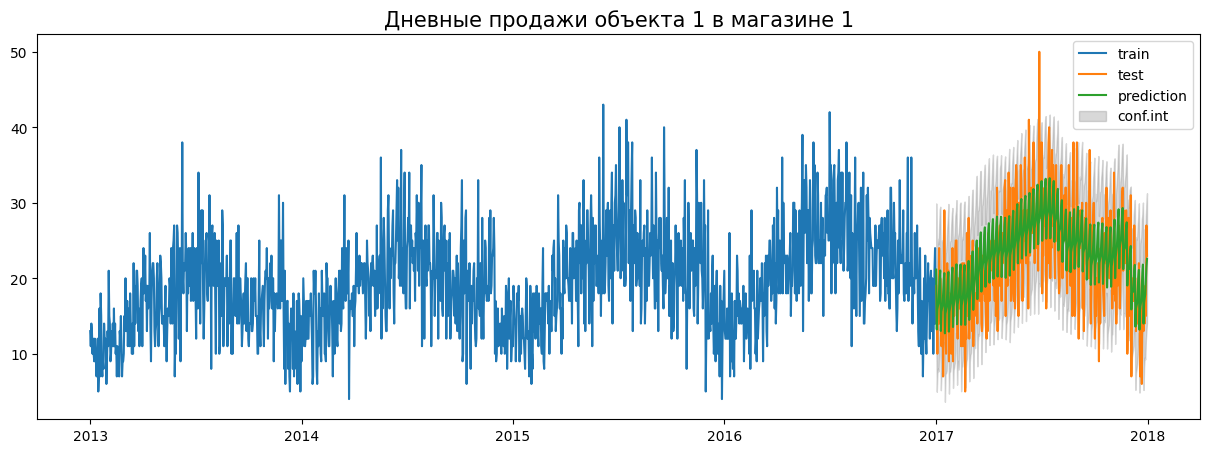

In [15]:
plot_results(data_train, data_test, y_prophet_forecast['yhat'], plot_conf_int=True,
             left_bound=y_prophet_forecast['yhat_lower'],
             right_bound=y_prophet_forecast['yhat_upper'])

In [16]:
add_results_in_comparison_table('Prophet', data_test, y_prophet_forecast['yhat'])

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153


In [17]:
prophet_model_with_holidays = Prophet(interval_width=0.95)
prophet_model_with_holidays.add_country_holidays(country_name='US')
prophet_model_with_holidays.fit(prophet_train_df)

14:49:55 - cmdstanpy - INFO - Chain [1] start processing
14:49:56 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
prophet_model_with_holidays.train_holiday_names

0                  New Year's Day
1                    Memorial Day
2                Independence Day
3                       Labor Day
4                    Veterans Day
5                    Thanksgiving
6                   Christmas Day
7        Christmas Day (observed)
8      Martin Luther King Jr. Day
9           Washington's Birthday
10                   Columbus Day
11    Independence Day (observed)
dtype: object

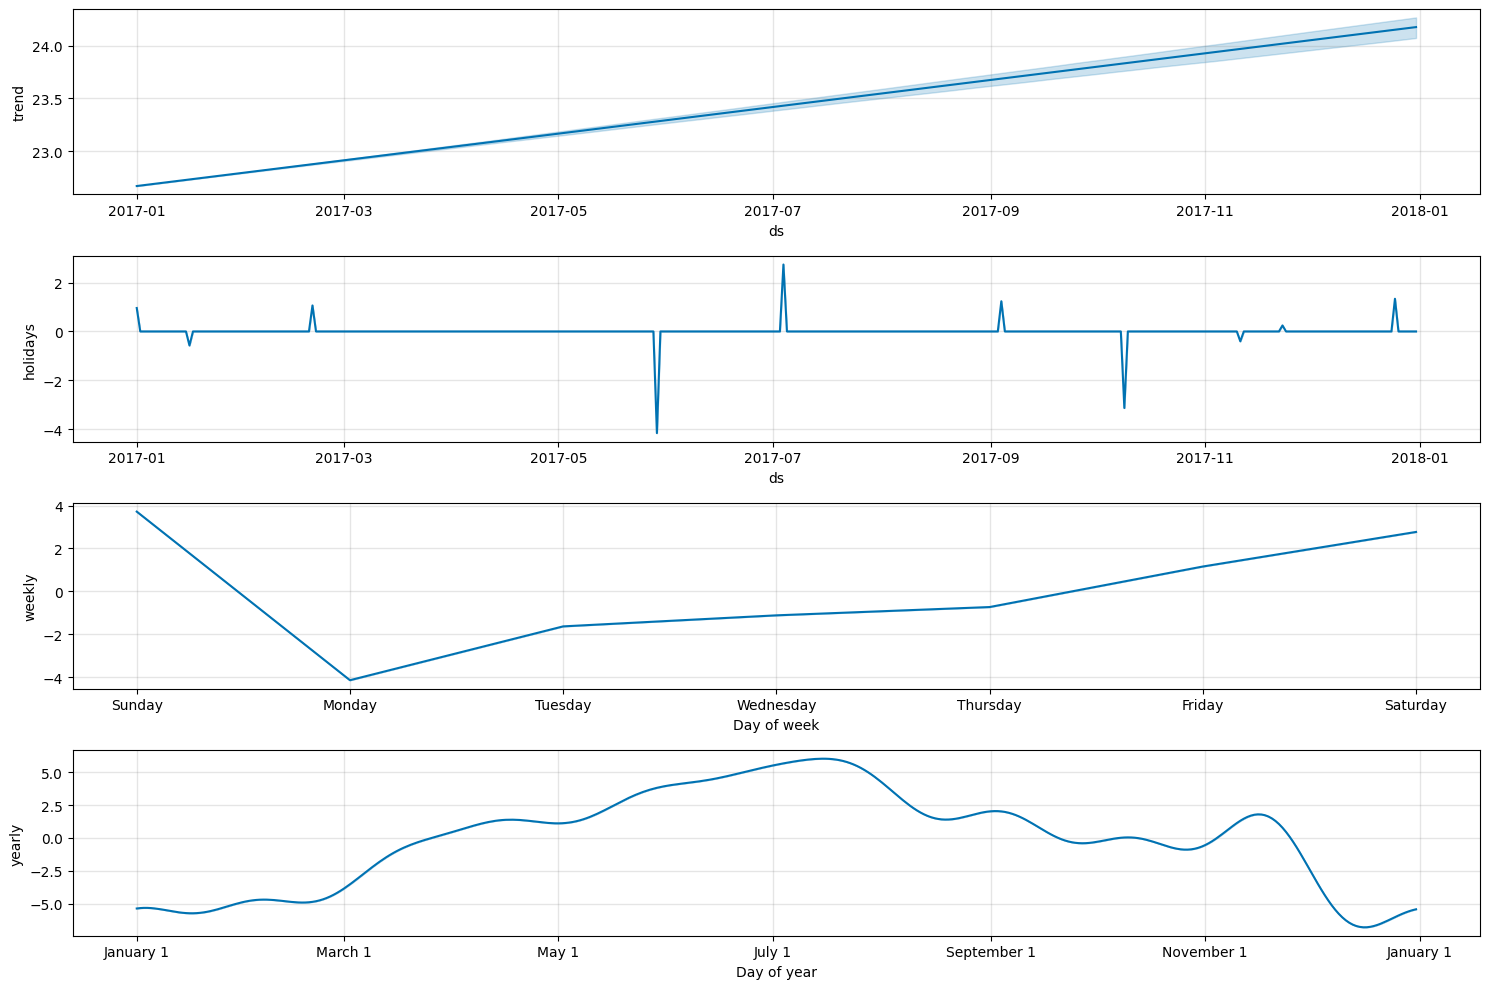

In [19]:
future = prophet_model_with_holidays.make_future_dataframe(
    periods=365, include_history=False
)
y_prophet_with_holidays_forecast = prophet_model_with_holidays.predict(future)
prophet_model_with_holidays.plot_components(y_prophet_with_holidays_forecast, figsize=(15, 10))
plt.show()

In [20]:
y_prophet_with_holidays_forecast['yhat']

0      21.988325
1      13.196748
2      15.727021
3      16.246140
4      16.623732
         ...    
360    17.259311
361    17.758917
362    19.750495
363    21.449684
364    22.470225
Name: yhat, Length: 365, dtype: float64

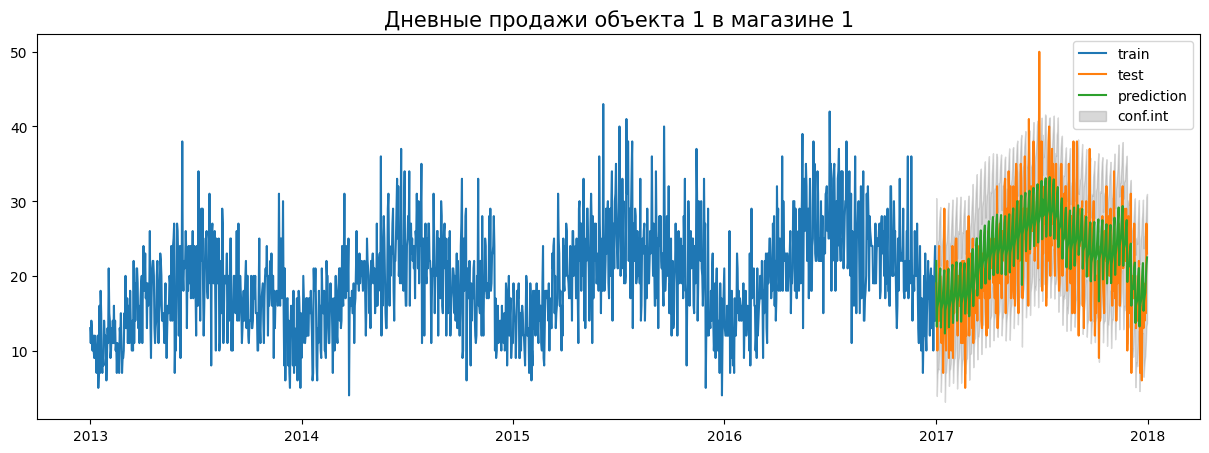

In [21]:
prophet_boxcox_preidction = y_prophet_with_holidays_forecast['yhat']

plot_results(data_train, data_test, prophet_boxcox_preidction, plot_conf_int=True,
             left_bound=y_prophet_with_holidays_forecast['yhat_lower'],
             right_bound=y_prophet_with_holidays_forecast['yhat_upper'])

In [22]:
add_results_in_comparison_table('Prophet + holidays', data_test, y_prophet_with_holidays_forecast['yhat'])

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Prophet + holidays,24.949507,4.061328,22.420432


In [23]:
from statsmodels.stats.proportion import proportion_confint

def check_predictive_interval(Y_to_test, left_bound, right_bound):
    '''
        Функция, которая проверяет предсказательный интервал.
    '''


    errors_number = ((np.array(Y_to_test) < left_bound) | (np.array(Y_to_test) > right_bound))

    left, _ = proportion_confint(count=np.sum(errors_number), 
                                 nobs=len(Y_to_test), 
                                 alpha=0.05, method='wilson'
                                 )

    status = "OK" if left < 0.05 else "ALERT"

    print(f"Pct. of errors: {np.mean(errors_number):.3f}, left bound: {round(left, 3)}, status: {status}")


In [24]:
check_predictive_interval(data_test, 
                          left_bound=y_prophet_with_holidays_forecast['yhat_lower'],
                          right_bound=y_prophet_with_holidays_forecast['yhat_upper'])

Pct. of errors: 0.085, left bound: 0.06, status: ALERT


Преобразование Бокса — Кокса:

In [25]:
prophet_boxcox_train_df = prophet_train_df.copy()

prophet_boxcox_train_df['y'], lambda_prophet = sps.boxcox(prophet_boxcox_train_df['y'])

In [26]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return (np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

In [27]:
prophet_boxcox_model = Prophet(interval_width=0.95)
prophet_boxcox_model.fit(prophet_boxcox_train_df)

future_boxcox = prophet_boxcox_model.make_future_dataframe(periods=365, include_history=False)
y_prophet_boxcox_forecast = prophet_boxcox_model.predict(future_boxcox)

y_prophet_boxcox_forecast['yhat'] = invboxcox(y_prophet_boxcox_forecast.yhat, lambda_prophet)
y_prophet_boxcox_forecast ['yhat_lower'] = invboxcox(y_prophet_boxcox_forecast.yhat_lower, lambda_prophet)
y_prophet_boxcox_forecast['yhat_upper'] = invboxcox(y_prophet_boxcox_forecast.yhat_upper, lambda_prophet)

14:49:58 - cmdstanpy - INFO - Chain [1] start processing
14:49:58 - cmdstanpy - INFO - Chain [1] done processing


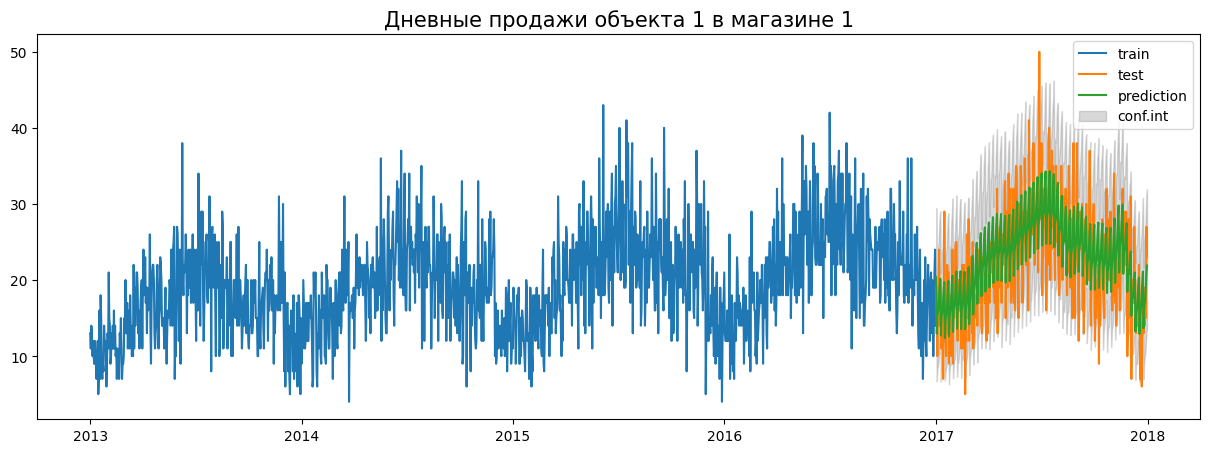

In [28]:
prophet_boxcox_preidction = y_prophet_boxcox_forecast['yhat']
plot_results(data_train, data_test, prophet_boxcox_preidction, plot_conf_int=True,
             left_bound=y_prophet_boxcox_forecast['yhat_lower'],
             right_bound=y_prophet_boxcox_forecast['yhat_upper'])

In [29]:
add_results_in_comparison_table('Prophet + boxcox', data_test, prophet_boxcox_preidction)

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Prophet + holidays,24.949507,4.061328,22.420432
2,Prophet + boxcox,24.172479,3.992453,21.729038


In [30]:
check_predictive_interval(data_test, 
                          left_bound=y_prophet_boxcox_forecast['yhat_lower'], 
                          right_bound=y_prophet_boxcox_forecast['yhat_upper'])

Pct. of errors: 0.066, left bound: 0.045, status: OK


## AutoARIMA

In [31]:
# m = 7 = недельная сезонность
arima_model = auto_arima(data_train, seasonal=True, m=7)

In [ ]:
y_arima_forecast, conf_int = arima_model.predict(n_periods=test_size, return_conf_int=True, alpha=0.05)

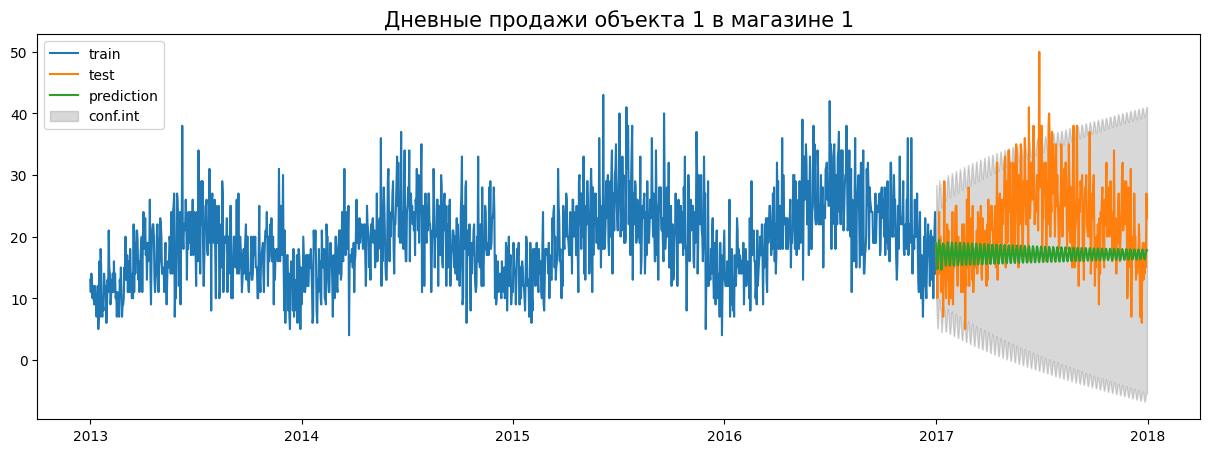

In [ ]:
plot_results(data_train, data_test, y_arima_forecast, plot_conf_int=True, 
             left_bound=conf_int.T[0], 
             right_bound=conf_int.T[1])

In [ ]:
add_results_in_comparison_table('Auto arima model', data_test, y_arima_forecast)

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Prophet + holidays,24.949507,4.061328,22.420432
2,Prophet + boxcox,24.172479,3.992453,21.729038
3,Auto arima model,70.907815,6.650232,28.894886


In [ ]:
check_predictive_interval(data_test,
                          left_bound=conf_int.T[0], 
                          right_bound=conf_int.T[1])

Pct. of errors: 0.038, left bound: 0.023, status: OK


Учтем годовую сезонность через ряды Фурье. 

In [ ]:
exog = pd.DataFrame({'date': data.index})
# exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog = exog.set_index(exog['date'])

# первые слагаемые в ряде Фурье
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:-test_size]
exog_to_test = exog.iloc[-test_size:]

In [ ]:
# debug, индексы должны быть одинаковыми иначе sarimax не работает
# data_train.index = pd.PeriodIndex(data_train.index, freq='D')
# data_test.index = pd.PeriodIndex(data_test.index, freq='D')


Причем период сезонности равен 365.25, так как через каждые 4 года случается високосный год, в котором 366 дней.

In [ ]:
arima_exog_model = auto_arima(y = data_train, 
                              exogenous = exog_to_train, 
                              seasonal = True, 
                              m=7,
                              trace=True)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=5.34 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=9794.141, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=9371.474, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8926.917, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=9792.141, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=9013.031, Time=0.20 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=8878.045, Time=1.65 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=6.12 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=9681.707, Time=0.89 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=8872.699, Time=2.03 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=8921.416, Time=0.97 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=7.53 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=9361.603, Time=1.06 sec
 ARIMA(2,1,1)(0,0,2)[7] intercept  

In [ ]:
y_arima_exog_forecast, conf_int_exog = arima_exog_model.predict(
    n_periods=test_size,
    exogenous=exog_to_test,
    
    return_conf_int=True,
    alpha=0.05
    )

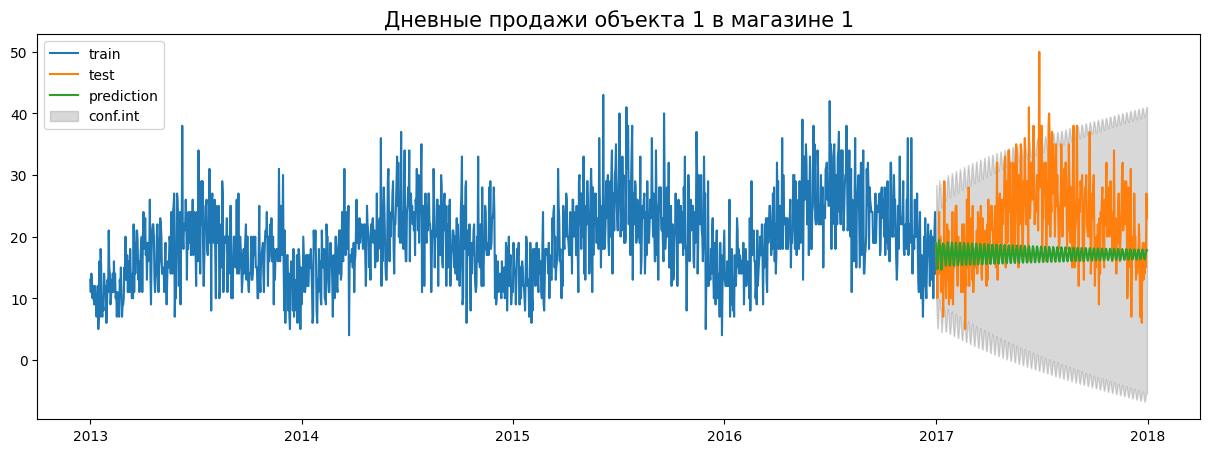

In [ ]:
plot_results(data_train, data_test, 
             y_arima_exog_forecast, plot_conf_int=True,
             left_bound=conf_int_exog.T[0], right_bound=conf_int_exog.T[1])

In [ ]:
add_results_in_comparison_table('Auto arima model wirh Fourier exog', data_test, y_arima_exog_forecast)

,method,MSE,MAE,MAPE
0,Auto arima model wirh Fourier exog,70.907815,6.650232,28.894886


In [ ]:
check_predictive_interval(data_test,left_bound=conf_int_exog.T[0], right_bound=conf_int_exog.T[1])

Pct. of errors: 0.038, left bound: 0.023, status: OK


In [ ]:
# сравнение обычной и экзогенной модели

In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1461
Model:             SARIMAX(3, 1, 5)x(0, 0, [1, 2], 7)   Log Likelihood               -4376.839
Date:                                Tue, 30 Jan 2024   AIC                           8775.678
Time:                                        23:52:24   BIC                           8833.827
Sample:                                    01-01-2013   HQIC                          8797.370
                                         - 12-31-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3021      6.994      0.043      0.966     -13.405      14.009
ar.L2          0.1792      8.707      0.021      0.984     -16.887      17.245
ar.L3         -0.9380      6.957     -0.135      0.893     -14.573      12.697
ma.L1         -1.1969      6.994     -0.171      0.864     -14.904      12.511
ma.L2          0.0679     14.972      0.005      0.996     -29.276      29.412
ma.L3          1.0980     14.603      0.075      0.940     -27.522      29.718
ma.L4         -0.8259      6.089     -0.136      0.892     -12.761      11.109
ma.L5         -0.0072      0.051     -0.142      0.887      -0.107       0.093
ma.S.L7        0.1314      0.028      4.673      0.000       0.076       0.187
ma.S.L14       0.1090      0.026      4.135      0.000       0.057       0.161
sigma2        23.5360      0.831     28.331      0.000      21.908      25.164
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                10.63
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima_exog_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1461
Model:             SARIMAX(3, 1, 5)x(0, 0, [1, 2], 7)   Log Likelihood               -4376.839
Date:                                Tue, 30 Jan 2024   AIC                           8775.678
Time:                                        23:52:24   BIC                           8833.827
Sample:                                    01-01-2013   HQIC                          8797.370
                                         - 12-31-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3021      6.994      0.043      0.966     -13.405      14.009
ar.L2          0.1792      8.707      0.021      0.984     -16.887      17.245
ar.L3         -0.9380      6.957     -0.135      0.893     -14.573      12.697
ma.L1         -1.1969      6.994     -0.171      0.864     -14.904      12.511
ma.L2          0.0679     14.972      0.005      0.996     -29.276      29.412
ma.L3          1.0980     14.603      0.075      0.940     -27.522      29.718
ma.L4         -0.8259      6.089     -0.136      0.892     -12.761      11.109
ma.L5         -0.0072      0.051     -0.142      0.887      -0.107       0.093
ma.S.L7        0.1314      0.028      4.673      0.000       0.076       0.187
ma.S.L14       0.1090      0.026      4.135      0.000       0.057       0.161
sigma2        23.5360      0.831     28.331      0.000      21.908      25.164
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                10.63
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# передаем параметры из прошлой модели
real_sarimax_model = SARIMAX(data_train, order=(3, 1, 5), seasonal_order=(0, 0, 2, 7),
    seasonal_periods=7,
    exog=exog_to_train).fit()


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02770D+00    |proj g|=  7.24249D-02


 This problem is unconstrained.



At iterate    5    f=  3.01773D+00    |proj g|=  3.46272D-02

At iterate   10    f=  3.01477D+00    |proj g|=  7.56850D-03

At iterate   15    f=  3.01436D+00    |proj g|=  2.18523D-03

At iterate   20    f=  3.01383D+00    |proj g|=  4.48833D-03

At iterate   25    f=  3.01377D+00    |proj g|=  4.12922D-03

At iterate   30    f=  3.01367D+00    |proj g|=  6.74261D-03

At iterate   35    f=  3.01348D+00    |proj g|=  2.65484D-03

At iterate   40    f=  3.01344D+00    |proj g|=  6.58600D-04

At iterate   45    f=  3.01344D+00    |proj g|=  4.84141D-04

At iterate   50    f=  3.01343D+00    |proj g|=  2.47274D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
y_sarimax_real_forecast = real_sarimax_model.predict(
    start=len(data_train),
    end=len(data_train) + len(data_test) - 1,
    # n_periods=test_size,
    exog=exog_to_test
    )

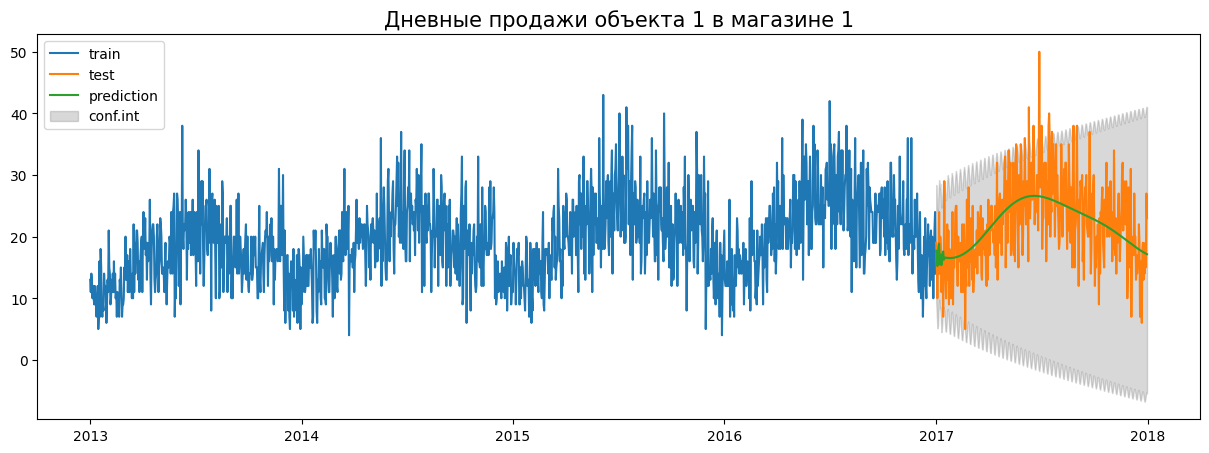

In [ ]:
plot_results(data_train, data_test, 
             y_sarimax_real_forecast, plot_conf_int=True,
             left_bound=conf_int_exog.T[0], right_bound=conf_int_exog.T[1])

In [ ]:
add_results_in_comparison_table('Original SARIMAX', data_test, y_sarimax_real_forecast)

,method,MSE,MAE,MAPE
0,Auto arima model wirh Fourier exog,70.907815,6.650232,28.894886
1,Original SARIMAX,32.621021,4.506235,23.676380


## TBATS

Модель учитывает несколько сезонностей, но не может принимать экзогенные признаки.

In [ ]:
tbats_estimator = TBATS(seasonal_periods=(7, 365.25), n_jobs=20)
model = tbats_estimator.fit(data_train)

In [ ]:
print(model.summary())

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [ 3 11]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.234955
Smoothing (Alpha): 0.015789
Seasonal Parameters (Gamma): [ 8.43667263e-04  1.61227440e-03 -1.80755703e-03 -1.37450474e-05]
AR coefficients []
MA coefficients []
Seed vector [ 3.81313824e+00 -2.74645415e-01 -1.69626587e-02  1.26129302e-01
 -5.67941864e-02  1.86125556e-01  1.01120904e-01 -5.00481084e-01
 -5.29879742e-02 -1.14033714e-01 -5.71844500e-03 -4.67508703e-02
  2.10869447e-05  3.17363653e-02  2.56748598e-02  4.95179412e-02
  3.09192993e-02  3.19082012e-02 -6.20531138e-02 -1.00282034e-01
 -7.52737801e-02  2.34408825e-02  6.82536086e-02  7.30941114e-02
  9.59125330e-03  1.53375541e-02 -1.72073271e-02 -3.43625403e-02
 -4.08392956e-03]

AIC 14974.983349


In [ ]:
tbats_forecast, confidence_info = model.forecast(steps=365, confidence_level=0.95)

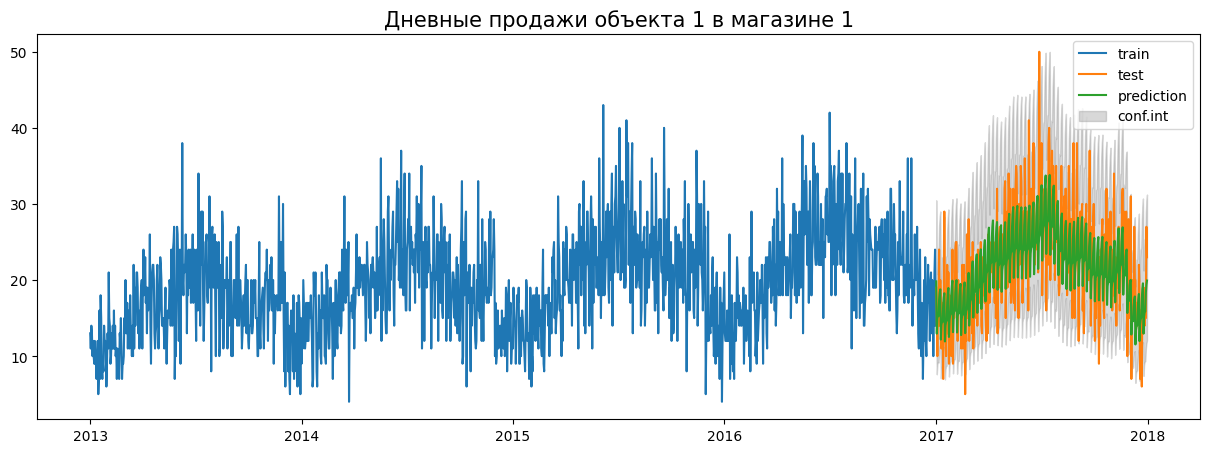

In [ ]:
plot_results(data_train, data_test, tbats_forecast, plot_conf_int=True, 
             left_bound=confidence_info['lower_bound'], 
             right_bound=confidence_info['upper_bound'])

In [ ]:
final_table = add_results_in_comparison_table('TBATS model', data_test, tbats_forecast)

In [ ]:
check_predictive_interval(data_test, 
                          left_bound=confidence_info['lower_bound'],
                          right_bound=confidence_info['upper_bound'])

Pct. of errors: 0.047, left bound: 0.029, status: OK


Видно, что процент ошибок примерно 5%, а значит, предсказательный интервал у модели корректен.

## ИТОГО

В даном ноутбуке было рассмотрено, как работать со следующими моделями:
    - Prophet;
    - SARIMAX с экзогенными признаками;
    - TBATS.

Лучше всего показала себя модель TBATS, так как она учитывает несколько сезонностей.

In [ ]:
final_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Prophet + holidays,24.949507,4.061328,22.420432
2,Prophet + boxcox,24.172479,3.992453,21.729038
3,Auto arima model,70.907815,6.650232,28.894886
4,Auto arima model wirh Fourier exog,70.907815,6.650232,28.894886
5,TBATS model,23.637445,3.857729,19.791148
